<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/MSLesion_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

In [1]:
#Run once per session
!pip install fastai2 -q
!pip install nibabel -q
!pip install scipy -q



     |████████████████████████████████| 184kB 4.8MB/s 


In [0]:
from fastai2.vision.all import *
import nibabel as nib
import scipy

Here are commands to zip from Mac:

zip -r Masks.zip . -i "./Nifti/*/*Mask.nii.gz"

zip -r FLAIRs.zip . -i "./Nifti/*/Sag_FLAIR_Std_N4_BET.nii.gz"

zip -r MPRAGEs.zip . -i "./Nifti/*/Sag_MPRAGE_Std_N4_BET.nii.gz"

zip -r BrainMasks.zip . -i "./Nifti/*/
Sag_MPRAGE_Std_N4_BET_mask.nii.gz"

zip -r Gads.zip . -i "./Nifti/*/Sag_Gad_Std_N4_BET.nii.gz


In [6]:

!rm -rf ./sample_data
!rm -rf ./labels
!rm -rf ./images


!mkdir ./FLAIRs; cd FLAIRs; unzip ../FLAIRs.zip
!mkdir ./Gads; cd Gads; unzip ../Gads.zip
!mkdir ./MPRAGEs; cd MPRAGEs; unzip ../MPRAGEs.zip
!mkdir ./Lesions; cd Lesions; unzip ../Masks.zip
!mkdir ./BrainMasks; cd BrainMasks; unzip ../BrainMasks.zip



mkdir: cannot create directory ‘./FLAIRs’: File exists
Archive:  ../FLAIRs.zip
  inflating: Nifti/0003/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0004/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0005/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0002/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0020/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0011/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0017/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0010/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0019/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0021/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0007/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0000/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0009/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0008/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0001/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0006/Sag_FLAIR_Std_N4_BET.nii.gz  
  inflating: Nifti/0024/Sag_FLAIR_Std_N4_BET.nii.gz  
  i

In [0]:
# now read the niftis, convert the image files to PNG
# and the brain mask + lesion mask to mask PNG

from scipy.ndimage import zoom
from PIL import Image

MAX_VAL = 255
DIM = 256  # assuming MRI  note that will make into a 3D vol of this size

def rescale_img(image, max_val=MAX_VAL):
    image = image - np.min(image)
    image = (np.maximum(image, 0) / image.max()) * max_val
    return (image)

def save_rgb(imgr, imgg, imgb, fname):
    dims = np.shape(imgr)
    if (DIM != dims[0]) or (DIM != dims[1]):
        imgr = zoom(imgr, (DIM/dims[0], DIM/dims[1]))
        imgg = zoom(imgg, (DIM/dims[0], DIM/dims[1]))
        imgb = zoom(imgb, (DIM/dims[0], DIM/dims[1]))
        print ("YY")
    rgbArray = np.zeros((DIM,DIM,3), 'uint8')
    rgbArray[..., 0] = imgr
    rgbArray[..., 1] = imgg
    rgbArray[..., 2] = imgb
    rgbArray = np.rot90(rgbArray)
    img = Image.fromarray(rgbArray)
    img.save(fname+".png")
    return

def save_gray(img, fname):
    dims = np.shape(img)
    if (DIM != dims[0]) or (DIM != dims[1]):
        print ("XX")
        img = zoom(img, (DIM/dims[0], DIM/dims[1]))
    print ("Max in mask is " + str(np.amax(img, axis=None)))
    img = np.rot90(img)
    img = Image.fromarray(np.uint8(img))
    img = img.convert("L")
    img.save(fname+".png")
    return


In [153]:
img_path = './images'   # where the PNG of the MRIs go
lbl_path = './labels'   # where the brain & lesion label images go

!rm -rf ./images
!rm -rf ./labels
!mkdir ./images
!mkdir ./labels


FLAIR_NAME = "Sag_FLAIR_Std_N4_BET.nii.gz"
MPRAGE_NAME = "Sag_MPRAGE_Std_N4_BET.nii.gz"
GAD_NAME = "Sag_Gad_Std_N4_BET.nii.gz"

LESION_NAME = FLAIR_NAME.replace ("_BET.nii.gz", "_BET_Lesion_ROI_Mask.nii.gz")
BRAIN_NAME = MPRAGE_NAME.replace ("_BET.nii.gz", "_BET_mask.nii.gz")

NUM_SUBJ = 25

for subj in range (NUM_SUBJ):
    subj_num = str(subj).zfill(4)
    tpath = os.path.join('./FLAIRs/Nifti', subj_num)
    if os.path.exists(os.path.join(tpath, FLAIR_NAME)):
        print (str(tpath))
        flair_img = nib.load(os.path.join(tpath, FLAIR_NAME))
        flair_img_data = flair_img.get_fdata()
        flair_img_data = rescale_img(flair_img_data, max_val=255)
        tpath = os.path.join('./MPRAGEs/Nifti', subj_num)
        if os.path.exists(os.path.join(tpath, MPRAGE_NAME)):
            print ("MPRAGE")
            MPRAGE_img = nib.load(os.path.join(tpath, MPRAGE_NAME))
            MPRAGE_img_data = MPRAGE_img.get_fdata()
            MPRAGE_img_data = rescale_img(MPRAGE_img_data, max_val=255)
            tpath = os.path.join('./Gads/Nifti', subj_num)
            if os.path.exists(os.path.join(tpath, GAD_NAME)):
                print ("Gad")
                Gad_img = nib.load(os.path.join(tpath, GAD_NAME))
                Gad_img_data = Gad_img.get_fdata()
                Gad_img_data = rescale_img(Gad_img_data, max_val=255)
                tpath = os.path.join('./Lesions/Nifti', subj_num)
                if os.path.exists(os.path.join(tpath, LESION_NAME)):
                    print ("Lesion")
                    lesions = nib.load(os.path.join(tpath, LESION_NAME))
                    lesion_data = lesions.get_fdata()
                    tpath = os.path.join('./BrainMasks/Nifti', subj_num)
                    if os.path.exists(os.path.join(tpath, BRAIN_NAME)):
                        print ("Brain")
                        brains = nib.load(os.path.join(tpath, BRAIN_NAME))
                        brain_data = brains.get_fdata()
                        print (str(np.count_nonzero(brain_data)) + "brain voxels")
                        dims = flair_img.shape
                        print (dims)
                        for z in range(dims[2]):
                            out_name = os.path.join(img_path, subj_num + '-' + str(z).zfill(4) + '-MRI')
                            if np.count_nonzero(lesion_data[:,:,z]) > 0:  # only use slices with lesions
                            # if True:
                                save_rgb(flair_img_data[:,:,z], MPRAGE_img_data[:,:,z], Gad_img_data[:,:,z], out_name)  # this is the MRI image
                                save_rgb(flair_img_data[:,:,z], flair_img_data[:,:,z], flair_img_data[:,:,z], out_name)  # this is the MRI image
                                out_name = os.path.join(lbl_path, subj_num + '-' + str(z).zfill(4) + '-Mask')
                                mask = lesion_data[:,:,z] + brain_data[:,:,z]
                                save_gray(mask, out_name)  # this is the mask image


./FLAIRs/Nifti/0000
MPRAGE
./FLAIRs/Nifti/0001
MPRAGE
./FLAIRs/Nifti/0002
MPRAGE
./FLAIRs/Nifti/0003
MPRAGE
Gad
Lesion
Brain
1570433brain voxels
(256, 256, 176)
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max in mask is 1.0
Max

First we need our filenames

In [154]:
fnames = get_image_files(img_path)
lbl_names = get_image_files(lbl_path)
print (fnames)

(#1026) [Path('images/0014-0045-MRI.png'),Path('images/0019-0106-MRI.png'),Path('images/0006-0057-MRI.png'),Path('images/0003-0103-MRI.png'),Path('images/0022-0091-MRI.png'),Path('images/0014-0116-MRI.png'),Path('images/0012-0133-MRI.png'),Path('images/0008-0104-MRI.png'),Path('images/0021-0080-MRI.png'),Path('images/0021-0103-MRI.png')...]


And now let's work with one of them

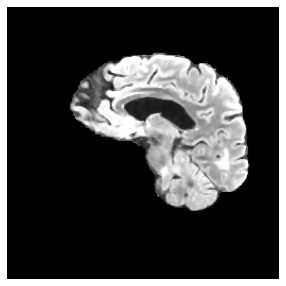

In [155]:
img_fn = fnames[48]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

In [0]:
def get_msk(img_name):
    # first replace the path for images with labels
    p = str(img_name).replace('images', 'labels')
    # now replace the MRI with mask part
    p = p.replace('MRI', 'Mask')
    return p

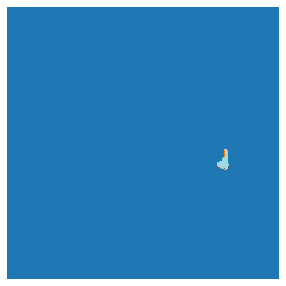

In [157]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [125]:
tensor(msk)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [0]:
#codes = np.loadtxt(path/'codes.txt', dtype=str); codes
codes = ['BG', 'Brain', 'Les', 'Enh']


# Transfer Learning between DataSets

Jeremy Howard at Fast.AI popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [127]:
sz = msk.shape; sz

(256, 256)

In [128]:
half = tuple(int(x/2) for x in sz); half

(128, 128)

In [0]:
MSLesion = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
#                   splitter=FileSplitter(path/'valid.txt'),  for now, don't worry about splitting by subject
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), 
                   Normalize.from_stats(*imagenet_stats)])

In [0]:
dls = MSLesion.dataloaders('./images', bs=8)

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

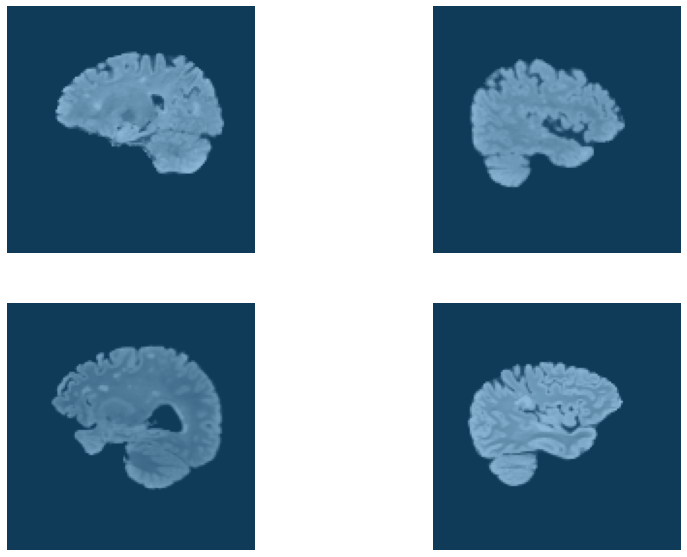

In [131]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [0]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [0]:
name2id = {v:k for k,v in enumerate(codes)}

In [96]:
name2id

{'BG': 0, 'Brain': 1, 'Enh': 3, 'Les': 2}

Awesome! Let's make an accuracy function

In [0]:
void_code = name2id['Les']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [0]:
def acc_MSLesion(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

# Model

## U-Net

![](http://deeplearning.net/tutorial/_images/unet.jpg)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in a configuration(`unet_config`) where we can declare a few things!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)

Along with this we will use the `Ranger` as optimizer function.

In [0]:
opt = ranger

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_MSLesion, config=config, opt_func=opt)

In [102]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 64 x 64     9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 64 x 64     128        True      
________________________________________________________________
ReLU                 8 x 64 x 64 x 64     0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 32 x 32     0          False     
________________________________________________________________
Conv2d               8 x 64 x 32 x 32     36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 32 x 32     128        True      
________________________________________________________________
ReLU                 8 x 64 x 32 x 32     0          False     
_________________________________________________

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.00015848931798245758)

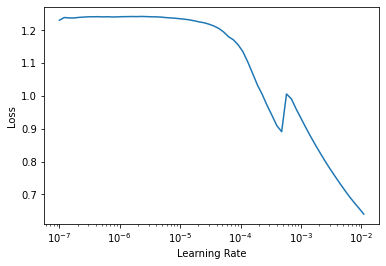

In [103]:
learn.lr_find()

In [0]:
lr = 3e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [105]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_MSLesion,time
0,0.006467,0.005624,0.999210,00:44
1,0.006363,0.005922,0.999210,00:43
2,0.005958,0.004275,0.999210,00:43
3,0.004369,0.003959,0.999210,00:43
4,0.003878,0.003922,0.999210,00:43
5,0.004572,0.003754,0.999210,00:43
6,0.003948,0.003429,0.999210,00:43
7,0.003725,0.003472,0.999210,00:43
8,0.003181,0.002987,0.999210,00:43
9,0.003116,0.002899,0.999234,00:43


In [0]:
learn.save('stage-1')
learn.load('stage-1');

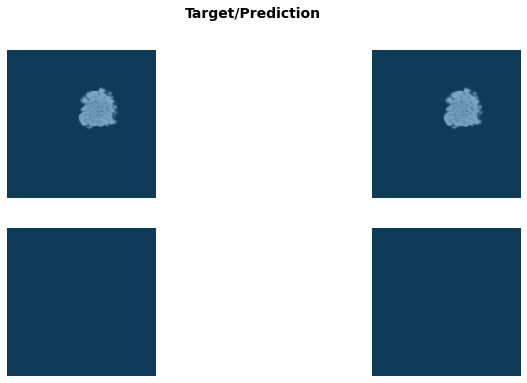

In [107]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [0]:
lrs = slice(lr/400, lr/4)

In [109]:
lr, lrs

(0.003, slice(7.5e-06, 0.00075, None))

In [0]:
learn.unfreeze()

And train for a bit more

In [111]:
learn.fit_flat_cos(12, lrs)

KeyboardInterrupt: ignored

Now let's save that model away

In [0]:
learn.save('model_1')

And look at a few results

In [0]:
learn.show_results(max_n=4, figsize=(18,8))

# Inference

Let's take a look at how to do inference with `test_dl`

In [0]:
dl = learn.dls.test_dl(fnames[:5])

In [0]:
dl.show_batch()

Let's do the first five pictures

In [0]:
preds = learn.get_preds(dl=dl)

In [0]:
preds[0].shape

Alright so we have a 5x32x360x480

In [0]:
len(codes)

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [0]:
pred_1 = preds[0][0]

In [0]:
pred_1.shape

Now let's take the argmax of our values

In [0]:
pred_arx = pred_1.argmax(dim=0)

And look at it

In [0]:
plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

In [0]:
pred_arx = pred_arx.numpy()

In [0]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [0]:
im = Image.fromarray(rescaled)

In [0]:
im

In [0]:
im.save('test.png')

Let's make a function to do so for our files

In [0]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [0]:
torch.save(preds[0][0], 'Image_1.pt')

In [0]:
pred_1 = torch.load('Image_1.pt')

In [0]:
plt.imshow(pred_1.argmax(dim=0))

# Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [0]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def ListSplitter(items):
  def _inner(it):
    val_mask = tensor([o.name in items for o in it])
    return [~val_mask, val_mask]
  return _inner

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size

In [0]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory

In [0]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights

In [0]:
config = unet_config(self_attention=True, act_cls=Mish)
opt = ranger

In [0]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, config=config,
                     opt_func=opt)
learn.load('model_1');

And now let's find our learning rate and train!

In [0]:
learn.lr_find()

In [0]:
lr = 1e-3

In [0]:
learn.fit_flat_cos(10, slice(lr))

In [0]:
learn.save('full_1')

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10); lrs

In [0]:
learn.fit_flat_cos(10, lrs)

In [0]:
learn.save('full_2')

In [0]:
learn.show_results(max_n=4, figsize=(18,8))

# Weighted Loss Functions

We can use weighted loss functions to help with class imbalancing. We need to do this because simply oversampling won't quite work here! So, how do we do it? `fastai2`'s `CrossEntropyLossFlat` is just a wrapper around `PyTorch`'s `CrossEntropyLoss`, so we can pass in a `weight` parameter (even if it doesn't show up in our autocompletion!) 




In [0]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

But what should this weight be? It needs to be a 1x`n` tensor, where `n` is the number of classes in your dataset. We'll use a quick example, where all but the last class has a weight of 90% and the last class has a weight of 110%

Also, as we are training on the GPU, we need the tensor to be so as well:

In [0]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [0]:
weights

Now we can pass this into `CrossEntropyLossFlat`

* **Note**: as this is segmentation, we need to make the axis to 1

In [0]:
learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

(or to pass it into `cnn_learner`)

In [0]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [0]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, loss_func=loss_func)